In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import shap

import os
import zipfile
import pandas as pd
import shutil
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = 'drive/MyDrive/Colab Notebooks/data_mining'
filename = 'liar_dataset.zip'

# Define file paths
zip_path = os.path.join(base_dir, filename)
extract_path = os.path.join(base_dir, "liar_dataset")

# Step 2: Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

Dataset extracted to: drive/MyDrive/Colab Notebooks/data_mining/liar_dataset


In [ ]:
# Load training, validation, and test datasets into DataFrames
train_path = os.path.join(extract_path, "train.tsv")
valid_path = os.path.join(extract_path, "valid.tsv")
test_path = os.path.join(extract_path, "test.tsv")

# Define column names based on the dataset structure
columns = [
    "id", "label", "statement", "subject", "speaker", "job",
    "state", "party", "barely_true", "false",
    "half_true", "mostly_true", "pants_on_fire", "context"
]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset as TorchDataset
from transformers import AutoModel, AutoTokenizer
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load datasets
train_df = pd.read_csv(train_path, sep='\t', header=None, names=columns)
valid_df = pd.read_csv(valid_path, sep='\t', header=None, names=columns)
test_df = pd.read_csv(test_path, sep='\t', header=None, names=columns)

# Drop rows with missing "speaker" and "party".
train_df.dropna(subset=["speaker", "party"], inplace=True)
valid_df.dropna(subset=["speaker", "party"], inplace=True)
test_df.dropna(subset=["speaker", "party"], inplace=True)

# Map labels to numeric values
label_map = {"pants-fire": 0, "false": 1, "barely-true": 2, "half-true": 3, "mostly-true": 4, "true": 5}
train_df["label"] = train_df["label"].map(label_map)
valid_df["label"] = valid_df["label"].map(label_map)
test_df["label"] = test_df["label"].map(label_map)

# One-hot encode metadata ('speaker' and 'party')
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
train_metadata = encoder.fit_transform(train_df[["speaker", "party"]])
valid_metadata = encoder.transform(valid_df[["speaker", "party"]])
test_metadata = encoder.transform(test_df[["speaker", "party"]])

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base")

def tokenize_text(text):
    """Tokenizes input text and returns input_ids and attention_mask."""
    encodings = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_tensors="pt")
    return encodings["input_ids"].squeeze(0), encodings["attention_mask"].squeeze(0)

# Tokenize statements
train_tokenized = train_df["statement"].apply(tokenize_text)
valid_tokenized = valid_df["statement"].apply(tokenize_text)
test_tokenized = test_df["statement"].apply(tokenize_text)

# Extract input_ids and attention_mask
train_df["input_ids"], train_df["attention_mask"] = zip(*train_tokenized)
valid_df["input_ids"], valid_df["attention_mask"] = zip(*valid_tokenized)
test_df["input_ids"], test_df["attention_mask"] = zip(*test_tokenized)

# Convert metadata and labels to lists
train_metadata = train_metadata.tolist()
valid_metadata = valid_metadata.tolist()
test_metadata = test_metadata.tolist()

train_labels = train_df["label"].tolist()
valid_labels = valid_df["label"].tolist()
test_labels = test_df["label"].tolist()

# Create dataset class
class HybridDataset(TorchDataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        return {
            "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),
            "metadata": torch.tensor(item["metadata"], dtype=torch.float),
            "labels": torch.tensor(item["label"], dtype=torch.long)
        }

# Convert to dataset format
train_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(train_df["input_ids"], train_df["attention_mask"], train_metadata, train_labels)]
valid_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
              for text, mask, meta, label in zip(valid_df["input_ids"], valid_df["attention_mask"], valid_metadata, valid_labels)]
test_data = [{"input_ids": text, "attention_mask": mask, "metadata": meta, "label": label}
             for text, mask, meta, label in zip(test_df["input_ids"], test_df["attention_mask"], test_metadata, test_labels)]

# Create PyTorch Dataset
train_dataset = HybridDataset(train_data)
valid_dataset = HybridDataset(valid_data)
test_dataset = HybridDataset(test_data)

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
# Define Hybrid Model with Monte Carlo Dropout
# Changed dropout from 0.3 to 0.1
# Best Hyperparameter Configuration:
#     dropout  learning_rate  weight_decay  metadata_weight  train_loss
# 11      0.1        0.00002          0.05              0.8    1.565326
class HybridBERTModelMC(nn.Module):
    def __init__(self, num_metadata_features, num_labels=6, dropout_prob=0.1):
        super(HybridBERTModelMC, self).__init__()
        self.bert = AutoModel.from_pretrained("roberta-base")
        self.text_fc = nn.Linear(768, 256)
        self.metadata_fc = nn.Linear(num_metadata_features, 128)
        self.dropout = nn.Dropout(dropout_prob)  # 🔥 Dropout before classification
        self.classifier = nn.Linear(256 + 128, num_labels)

    def forward(self, input_ids, attention_mask, metadata_features):
        text_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        text_features = torch.relu(self.text_fc(text_output))
        metadata_features = torch.relu(self.metadata_fc(metadata_features))
        combined = torch.cat((text_features, metadata_features), dim=1)
        combined = self.dropout(combined)  # 🔥 Apply dropout even in inference
        return self.classifier(combined)

In [ ]:
# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_metadata_features = len(train_metadata[0])
model = HybridBERTModelMC(num_metadata_features=num_metadata_features).to(device)

# Define Loss Function and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        metadata = batch["metadata"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask, metadata)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-5-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-5-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Epoch 1/10, Loss: 1.7464
Epoch 2/10, Loss: 1.7116
Epoch 3/10, Loss: 1.6618
Epoch 4/10, Loss: 1.5781
Epoch 5/10, Loss: 1.4433
Epoch 6/10, Loss: 1.2842
Epoch 7/10, Loss: 1.1016
Epoch 8/10, Loss: 0.9266
Epoch 9/10, Loss: 0.7545
Epoch 10/10, Loss: 0.6283


In [ ]:
# Save Model
torch.save(model.state_dict(), os.path.join(base_dir, "hybrid_mc_dropout_model_r10.pth"))
print("Model saved as hybrid_mc_dropout_model.pth")


Model saved as hybrid_mc_dropout_model.pth


In [ ]:

# Evaluation Function
def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            metadata = batch["metadata"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask, metadata)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return accuracy, precision, recall, f1, all_preds, all_labels

# Evaluate Model
print("Evaluating on Test Set...")
hybridmc_results = evaluate(model, test_dataloader)

Evaluating on Test Set...


<ipython-input-5-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-5-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2755
Precision: 0.2908, Recall: 0.2755, F1-Score: 0.2701


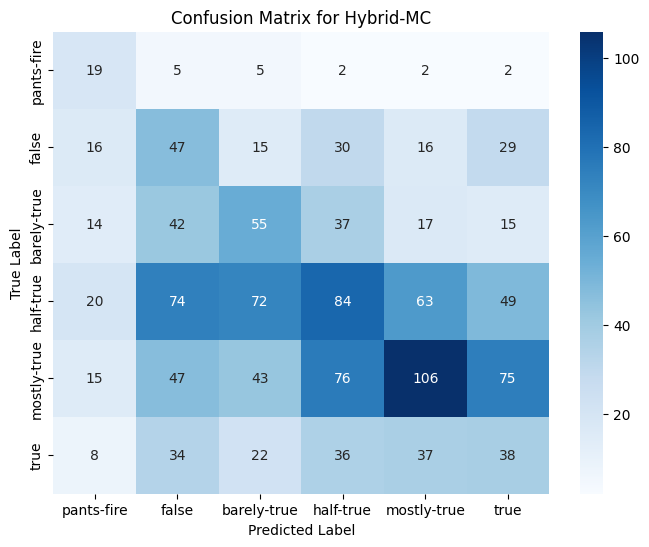

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

plot_confusion_matrix(hybridmc_results[4], hybridmc_results[5], title="Confusion Matrix for Hybrid-MC")

<ipython-input-5-39db6c3a3bc4>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "input_ids": torch.tensor(item["input_ids"], dtype=torch.long),
<ipython-input-5-39db6c3a3bc4>:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "attention_mask": torch.tensor(item["attention_mask"], dtype=torch.long),


Accuracy: 0.2565
Precision: 0.2641, Recall: 0.2565, F1-Score: 0.2461


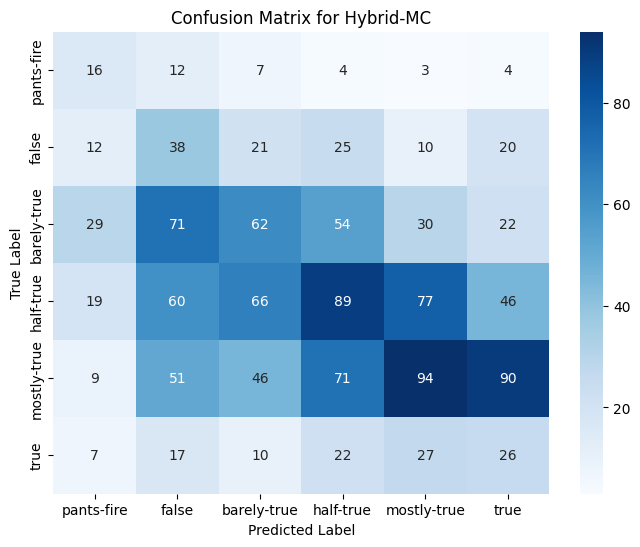

In [ ]:
hybridmc2_results = evaluate(model, test_dataloader)
plot_confusion_matrix(hybridmc2_results[4], hybridmc2_results[5], title="Confusion Matrix for Hybrid-MC")